In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# AutoTheta Model

> Step-by-step guide on using the `AutoTheta Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

The text in this article is copied from and inspired by:
1. [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). “Models for optimising the theta method and their relationship to state space models”. International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243).
2. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html)

## Table of Contents

* [Introduction](#introduction)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of AutoTheta with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction<a class="anchor" id="introduction"></a>

The `AutoTheta` model in `StatsForecast` automatically selects the best **Theta model** based on the **mean squared error (MSE)**. In this section, we will discuss each of the models that `AutoTheta` considers and then explain how it selects the best one.

### 1. Standard Theta Model (STM)

The **Standard Theta Model** is the original version of the Theta model introduced by Assimakopoulos and Nikolopoulos (2000). It decomposes a time series into two modified versions of the original series, called **theta lines**. These lines are created by applying a linear transformation to the second differences of the original series, controlled by a parameter called **theta $\theta$**. One theta line captures the long-term trend, while the other captures short-term fluctuations. The two theta lines are then combined to produce the final forecast. The STM assumes that model parameters remain constant over time.

### 2. Optimized Theta Model (OTM)

The **Optimized Theta Model** extends STM by searching for the best theta parameters rather than using fixed values. This optimization step allows the model to better fit series with higher variability.

### 3. Dynamic Standard Theta Model (DSTM)

The **Dynamic Standard Theta Model** allows STM to adapt over time. Instead of keeping parameters static, it updates them dynamically as new data becomes available. This dynamic behavior can be useful when forecasting series with evolving trends or seasonality.

### 4. Dynamic Optimized Theta Model (DOTM)

The **Dynamic Optimized Theta Model** combines features of both OTM and DSTM. Like OTM, it optimizes the theta parameters. Like DSTM, it updates the model dynamically with new data.

## How AutoTheta Selects the Best Model

1. `AutoTheta` fits all four variants of the Theta model (STM, OTM, DSTM, and DOTM) to your data.
2. Each model is evaluated using cross-validation or a hold-out validation strategy, depending on the configuration.
3. The model that achieves the lowest mean squared error (MSE) is selected.
4. The selected model is then used to generate the forecast.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} 
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation). 
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import pandas as pd

import scipy.stats as stats

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


### Read Data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/candy_production.csv")
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1972-01-01,85.6945,1
1,1972-02-01,71.8200,1
2,1972-03-01,66.0229,1
3,1972-04-01,64.5645,1
4,1972-05-01,65.0100,1


In [ ]:
print(df.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints aa random series from the dataset and is useful for basic EDA.

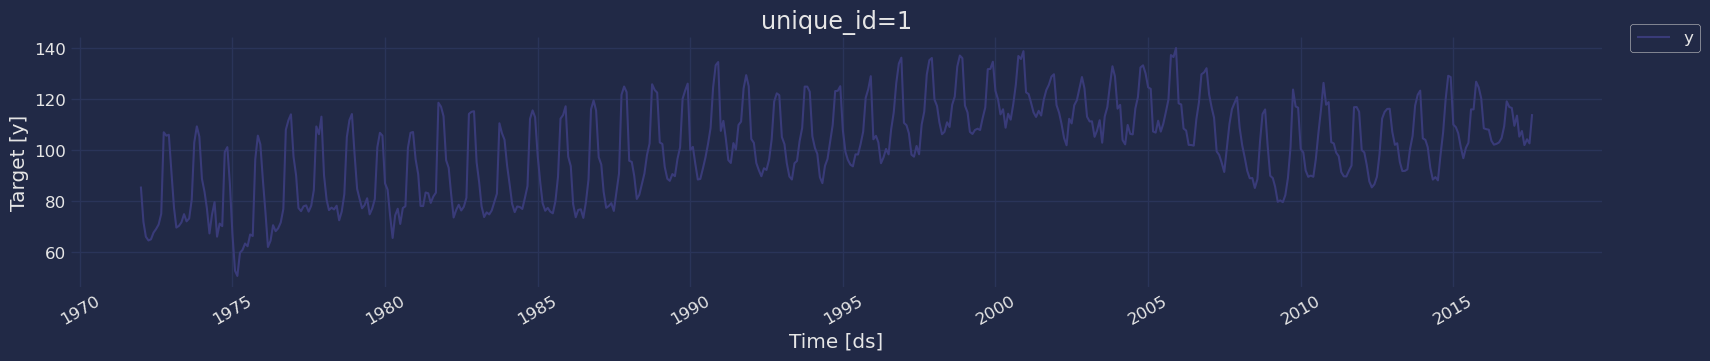

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

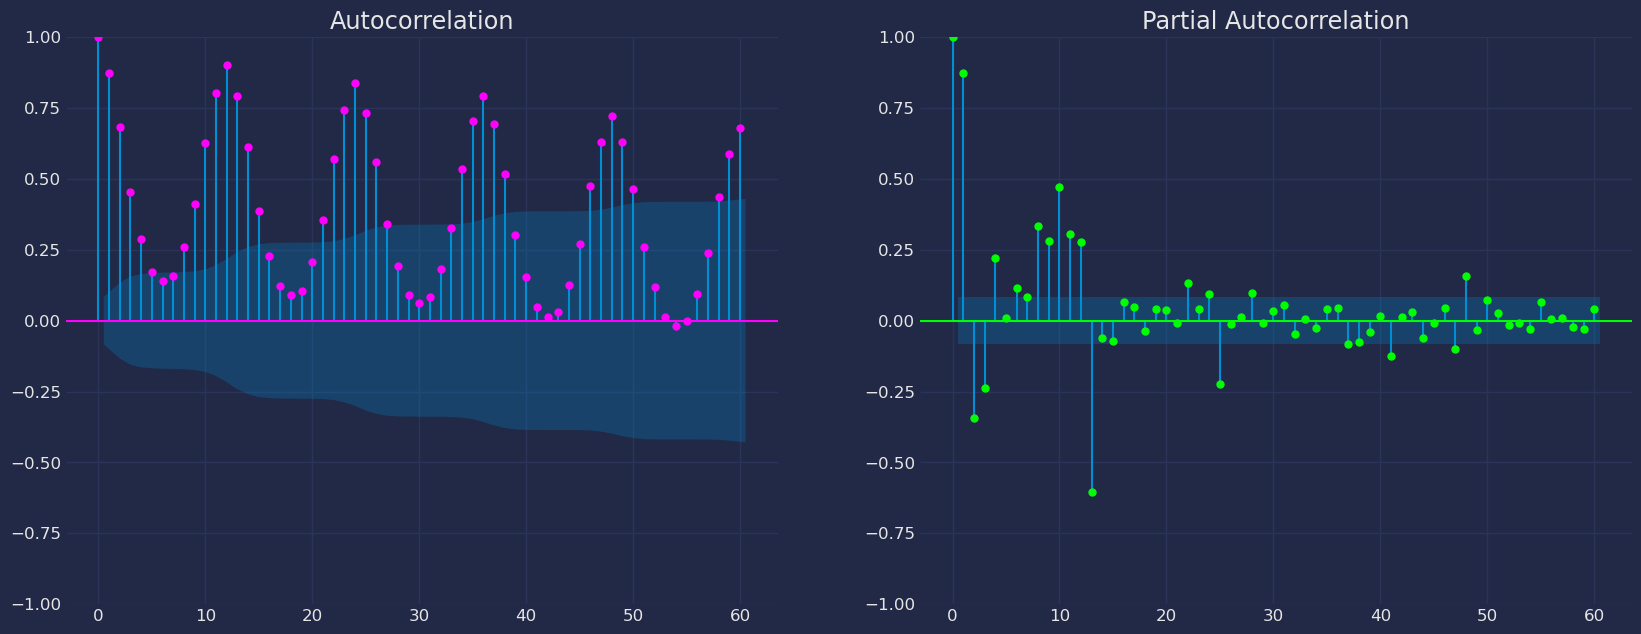

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `AutoTheta` model
2. Data to test our model

For the test data we will use the last 12 months to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2016-08-01']
test = df[df.ds>'2016-08-01']

In [ ]:
train.shape, test.shape

((536, 3), (12, 3))

Now let's plot the training data and the test data.

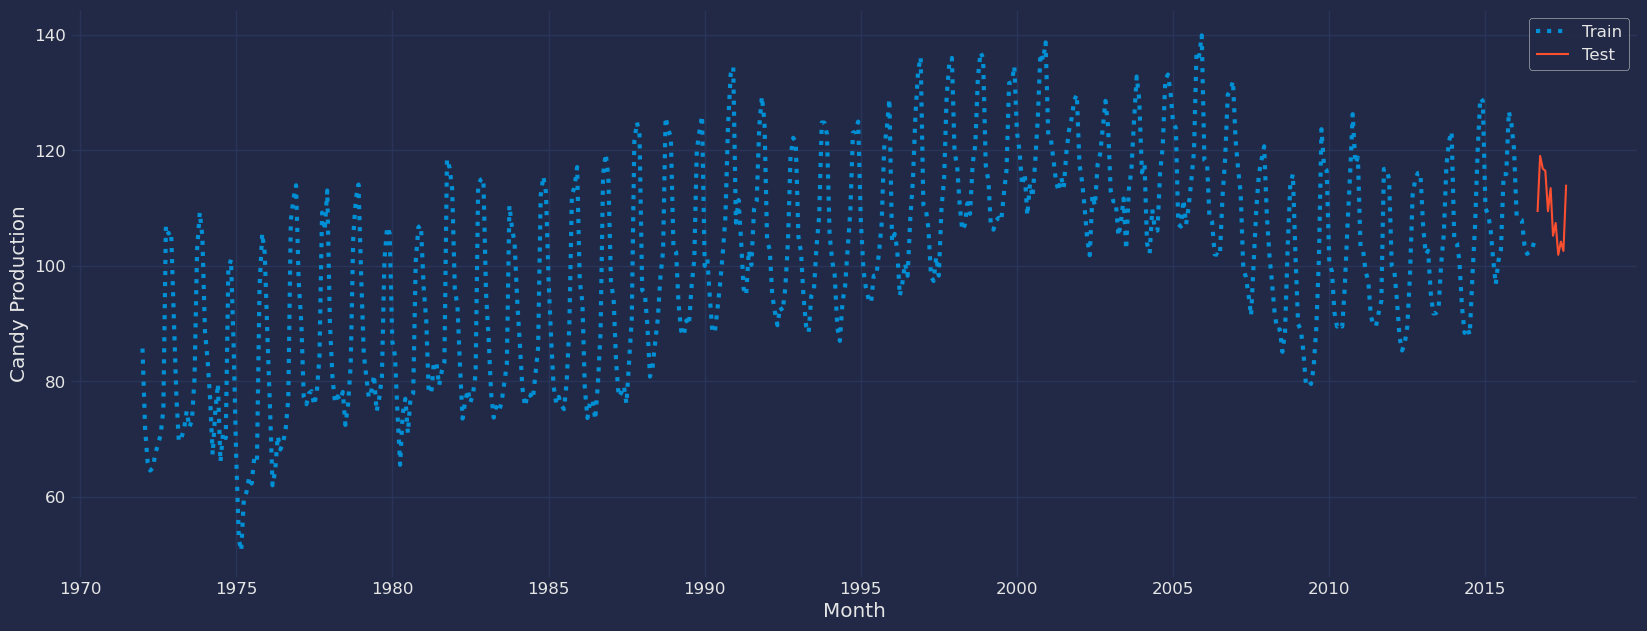

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linewidth=3, linestyle=":")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.ylabel("Candy Production")
plt.xlabel("Month")
plt.show()

## Implementation of AutoTheta with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoTheta

### Instantiate Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful.season_length.

Automatically selects the best Theta (Standard Theta Model `(‘STM’)`, Optimized Theta Model `(‘OTM’)`, Dynamic Standard Theta Model `(‘DSTM’)`, Dynamic Optimized Theta Model `(‘DOTM’))` model using mse.

In [ ]:
season_length = 12 # Monthly data
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [AutoTheta(season_length=season_length,
                     decomposition_type="additive",
                     model="STM")]


We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='MS')

### Fit Model

In [ ]:
sf.fit(df=train)

StatsForecast(models=[AutoTheta])

Let's see the results of our Theta model. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'mse': 100.57831864069415,
 'amse': array([26.13585578, 38.60211513, 44.70605915]),
 'fit': results(x=array([258.45064973,   0.7664297 ]), fn=100.57831864069415, nit=32, simplex=array([[250.37338496,   0.76970741],
        [232.03915522,   0.76429422],
        [258.45064973,   0.7664297 ]])),
 'residuals': array([-2.14815337e+02, -6.20562800e+01, -2.13256707e+01, -1.25845480e+01,
        -1.19719350e+01, -9.40876632e+00, -8.60141525e+00, -9.00054652e+00,
        -1.98778836e+00,  3.14564857e+01,  1.98519673e+01,  2.04962370e+01,
         4.98120196e+00, -1.08735375e+01, -1.12328024e+01, -8.08115377e+00,
        -9.98197589e+00, -8.39937098e+00, -1.25789505e+01, -1.05952806e+01,
         8.47229127e-01,  2.25644616e+01,  2.54401546e+01,  1.73989716e+01,
         2.40287275e+00, -2.53475866e+00, -8.00591135e+00, -1.79241479e+01,
        -6.36590693e+00, -5.76986468e+00, -2.26766759e+01, -8.95260931e+00,
        -7.19719166e+00,  2.74032238e+01,  2.21368457e+01,  6.43171676e+00,
        

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,-214.815337
1,-62.056280
2,-21.325671
...,...
533,-12.076379
534,-10.073890
535,-9.392073


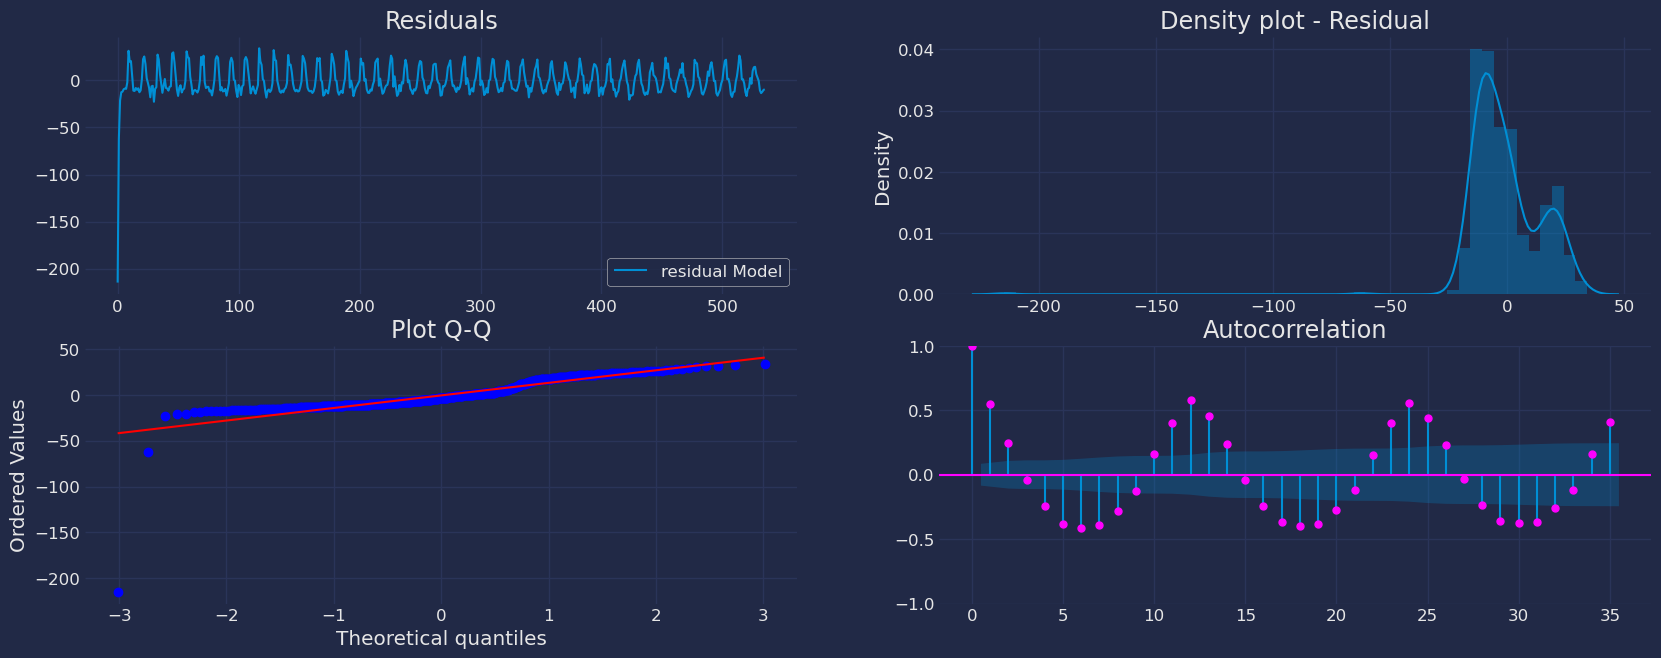

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)

residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [ ]:
# Prediction
Y_hat = sf.forecast(df=train, h=horizon, fitted=True)
Y_hat

,unique_id,ds,AutoTheta
0,1,2016-09-01,111.075915
1,1,2016-10-01,129.111292
2,1,2016-11-01,131.296093
...,...,...,...
9,1,2017-06-01,101.125782
10,1,2017-07-01,99.870548
11,1,2017-08-01,106.021718


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,unique_id,ds,y,AutoTheta
0,1,1972-01-01,85.6945,300.509837
1,1,1972-02-01,71.8200,133.876280
2,1,1972-03-01,66.0229,87.348571
3,1,1972-04-01,64.5645,77.149048
4,1,1972-05-01,65.0100,76.981935


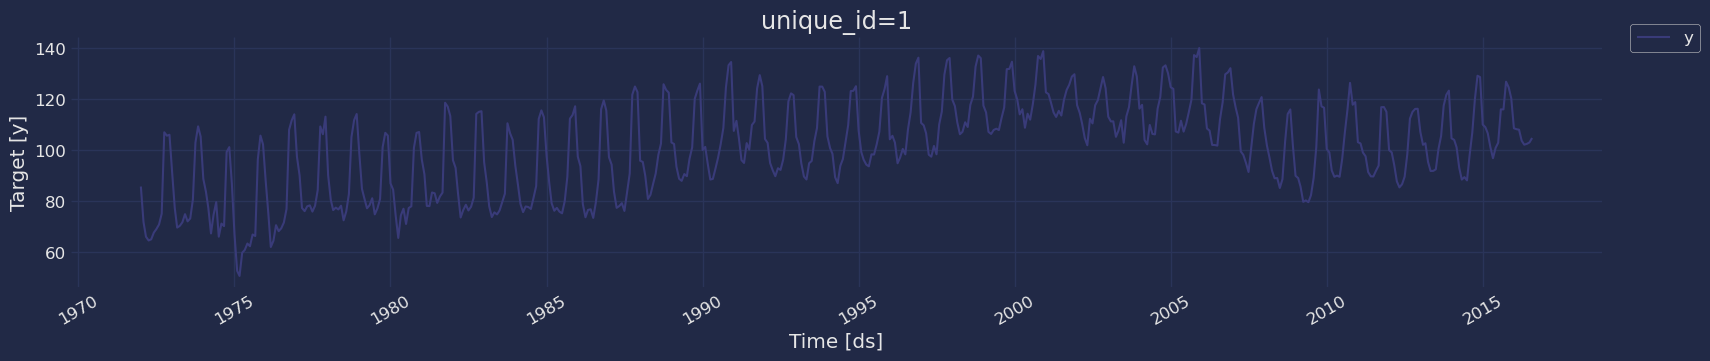

In [ ]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(df=train, h=horizon, level=[95])

,unique_id,ds,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95
0,1,2016-09-01,111.075915,90.139234,136.011109
1,1,2016-10-01,129.111292,94.795409,160.387128
2,1,2016-11-01,131.296093,90.579813,168.268538
...,...,...,...,...,...
9,1,2017-06-01,101.125782,41.186268,159.159903
10,1,2017-07-01,99.870548,35.144354,152.867267
11,1,2017-08-01,106.021718,38.753454,166.048584


In [ ]:
# Merge the forecasts with the true values
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,y,unique_id,AutoTheta
0,2016-09-01,109.3191,1,111.075915
1,2016-10-01,119.0502,1,129.111292
2,2016-11-01,116.8431,1,131.296093
...,...,...,...,...
9,2017-06-01,104.2022,1,101.125782
10,2017-07-01,102.5861,1,99.870548
11,2017-08-01,114.0613,1,106.021718


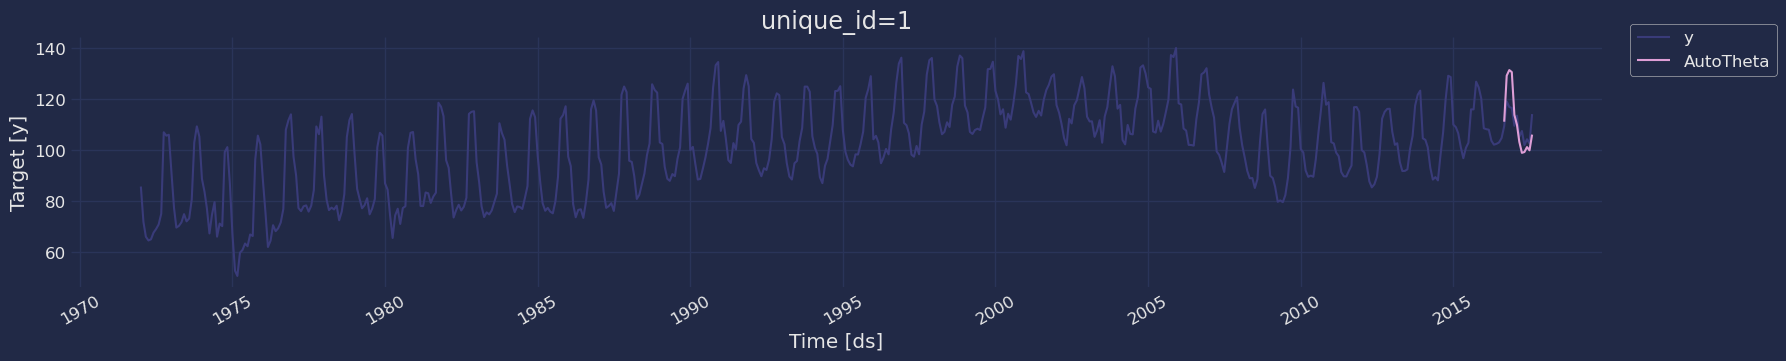

In [ ]:
sf.plot(train, Y_hat1)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon)

,unique_id,ds,AutoTheta
0,1,2016-09-01,111.075915
1,1,2016-10-01,129.111292
2,1,2016-11-01,131.296093
...,...,...,...
9,1,2017-06-01,101.125782
10,1,2017-07-01,99.870548
11,1,2017-08-01,106.021718


In [ ]:
forecast_df = sf.predict(h=horizon, level=[95])
forecast_df

,unique_id,ds,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95
0,1,2016-09-01,111.075915,90.139234,136.011109
1,1,2016-10-01,129.111292,94.795409,160.387128
2,1,2016-11-01,131.296093,90.579813,168.268538
...,...,...,...,...,...
9,1,2017-06-01,101.125782,41.186268,159.159903
10,1,2017-07-01,99.870548,35.144354,152.867267
11,1,2017-08-01,106.021718,38.753454,166.048584


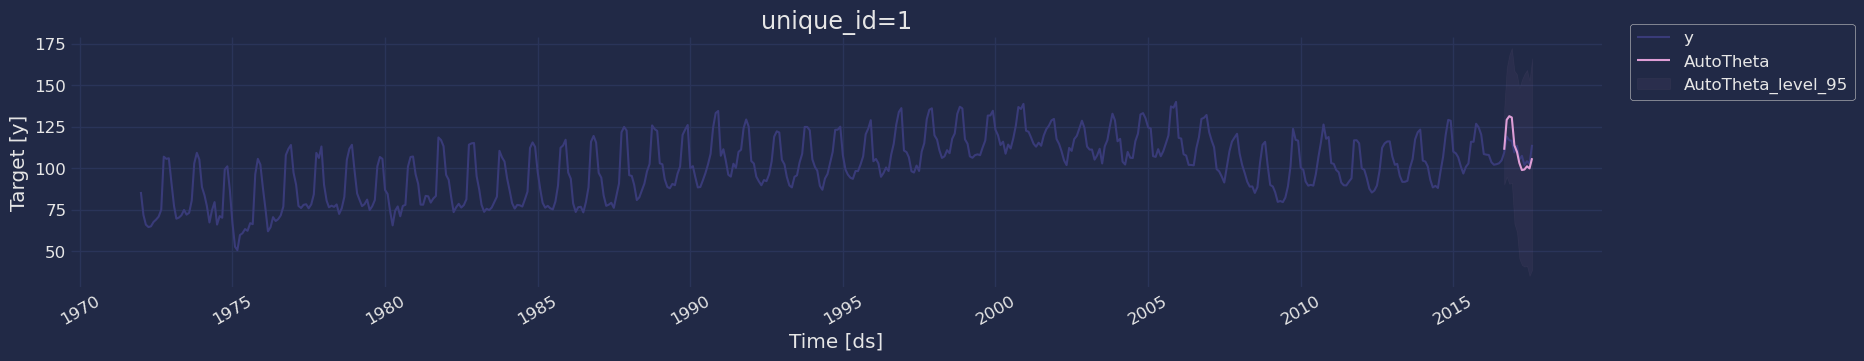

In [ ]:
sf.plot(train, test.merge(forecast_df), level=[95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(
    df=train,
    h=horizon,
    step_size=12,
    n_windows=5
)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` series identifier.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,unique_id,ds,cutoff,y,AutoTheta
0,1,2011-09-01,2011-08-01,93.9062,98.167469
1,1,2011-10-01,2011-08-01,116.7634,116.969932
2,1,2011-11-01,2011-08-01,116.8258,119.135142
...,...,...,...,...,...
57,1,2016-06-01,2015-08-01,102.4044,109.600469
58,1,2016-07-01,2015-08-01,102.9512,108.260160
59,1,2016-08-01,2015-08-01,104.6977,114.248270


## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    test.merge(Y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=season_length), ufl.rmse, ufl.smape],
    train_df=train,
)

,unique_id,metric,AutoTheta
0,1,mae,6.281513
1,1,mape,0.055683
2,1,mase,1.212473
3,1,rmse,7.683669
4,1,smape,0.027399


## References <a class="anchor" id="references"></a>

1. [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). “Models for optimising the theta method and their relationship to state space models”. International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243).
2. [Nixtla AutoTheta API](../../models#class-autotheta)
3. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
4. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html)
5. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).